<a href="https://colab.research.google.com/github/WizardOfCodes442/student-facial-biometric-project/blob/main/testingcnnwithobamapic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


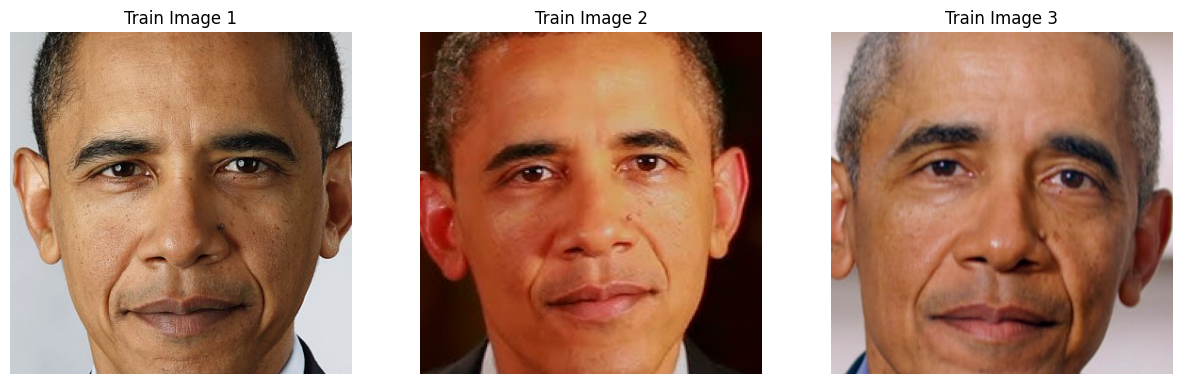

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


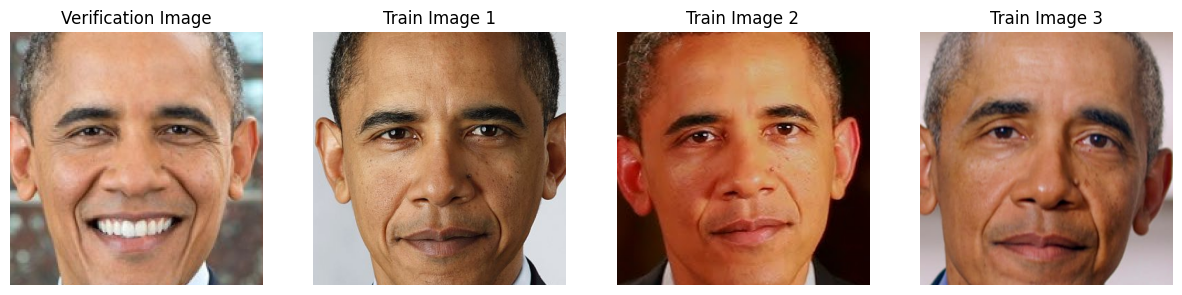

Match: Same person, Confidence_level = 0.94598967


In [3]:
import cv2
import numpy as np
import requests
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the MobileNetV2 model
def load_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='softmax')
    ])
    return model

# Download an image from a URL
def download_image(url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        image = np.asarray(bytearray(response.raw.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return image
    else:
        print(f"Error downloading image from URL: {url}")
        return None

# Preprocess image for the model
def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224))
    processed_image = preprocess_input(resized_image)
    return processed_image

# Extract face encoding from the image
def extract_face_encoding(model, image):
    processed_image = preprocess_image(image)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
    encoding = model.predict(processed_image)
    return encoding.flatten()

# Load the face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect and extract face from an image
def detect_face(image):
    if image is None:
        return None, None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, 1.1, 4)

    if len(faces) == 0:
        return None, image

    x, y, w, h = faces[0]  # Take the first detected face
    detected_face = image[y:y+h, x:x+w]  # Cropped face
    return detected_face, image[y:y+h, x:x+w]  # Return cropped face and full image

# Show image side by side
def show_images_side_by_side(images, titles=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

# URLs for 3 training images and 1 verification image (replace with your actual URLs)
train_image_urls = [
    "https://tile.loc.gov/storage-services/service/pnp/ppbd/00300/00358v.jpg",
    "https://i.ytimg.com/vi/BdjoHA5ocwU/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLBzFCX11mQ0tmO692NyJopkOnlT5Q",
    "https://politico.eu/cdn-cgi/image/width=1160,height=703,fit=crop,quality=80,onerror=redirect,format=auto/wp-content/uploads/2020/05/GettyImages-1225292516.jpg"
]
verify_image_url = "https://cdn.antaranews.com/cache/1200x800/2013/01/2013012143.jpg"

# Load the MobileNetV2 model
model = load_model()

# Load and process the training images
train_encodings = []
detected_faces_train = []

for url in train_image_urls:
    train_image = download_image(url)

    if train_image is None:
        print(f"Failed to download or process training image from {url}")
        continue

    train_face, full_image = detect_face(train_image)

    if train_face is not None:
        train_encoding = extract_face_encoding(model, train_face)
        train_encodings.append(train_encoding)
        detected_faces_train.append(train_face)
    else:
        print(f"No face detected in training image from {url}")

# Show all detected faces side by side
if detected_faces_train:
    show_images_side_by_side(detected_faces_train, ["Train Image 1", "Train Image 2", "Train Image 3"])

# Average the encodings from the 3 training images
if len(train_encodings) == 3:
    averaged_encoding = np.mean(train_encodings, axis=0)
else:
    print("Not enough valid training images with detected faces.")
    exit()

# Load and process the verification image
verify_image = download_image(verify_image_url)
verify_face, full_verify_image = detect_face(verify_image)

if verify_face is None:
    print("No face detected in the verification image.")
else:
    # Extract encoding for the verification image
    verify_encoding = extract_face_encoding(model, verify_face)

    # Show the verification face and training faces side by side
    show_images_side_by_side([verify_face] + detected_faces_train, ["Verification Image", "Train Image 1", "Train Image 2", "Train Image 3"])

    # Compare the averaged encoding with the verification encoding
    similarity = cosine_similarity([averaged_encoding], [verify_encoding])[0][0]

    # Define a threshold (0.9 is often a good threshold for face matching)
    if similarity > 0.9:
        print("Match: Same person, Confidence_level = " + str(similarity))
    else:
        print("Different people")

